# Import libraries 


In [1]:
# Basic libraries
import numpy as np
import pandas as pd 
#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Load the Dataset

In [2]:
df=pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


### Variable prensentation
Here are all the columns of the DataSet :  

<li> show_id : Id of the Netflix item, type : str                  
<li> type : "Movie" or " TV shows" only, type : str 
<li>title: Name of the item, type : str
<li>director: Name of the director of the item, type : str
<li>cast: Actors in the item, type : str            
<li>country : Country of the item, type : str
<li>date_added : Date of release on Netflix, type : str
<li>release_year : Public data of release, type : int
<li>rating : Rating, type : str
<li>duration: duration of the item : season for TV shows, minutes for movies, type : str
<li>listed_in : Genre of the item, type : str
<li>description: Details about the history of the movie, type : str


In [3]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [4]:
print('The DataFrame contains {} lines and {} columns. The number of movies represents the number of lines and the movies features represent the columns'.format(df.shape[0],df.shape[1]))

The DataFrame contains 7787 lines and 12 columns. The number of movies represents the number of lines and the movies features represent the columns


# Exploratory Data Analysis
### Count types of different movies

Text(0.5, 1.0, 'Repartition of Items by type')

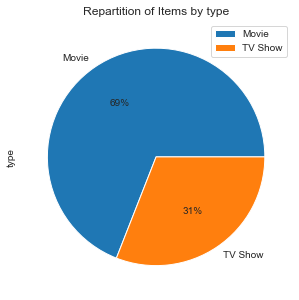

In [5]:
plt.figure(figsize=(5, 5))
df['type'].value_counts().plot.pie(autopct='%1.0f%%')
plt.legend()
plt.title('Repartition of Items by type')

### Visualise a calendar of items release 

In [6]:
df_dates = df[['date_added']].dropna()

df_dates['month'] = df_dates['date_added'].apply(lambda x : x.lstrip().split(' ')[0])
df_dates['year'] = df_dates['date_added'].apply(lambda x : x.split(', ')[-1])
mois = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][::-1]

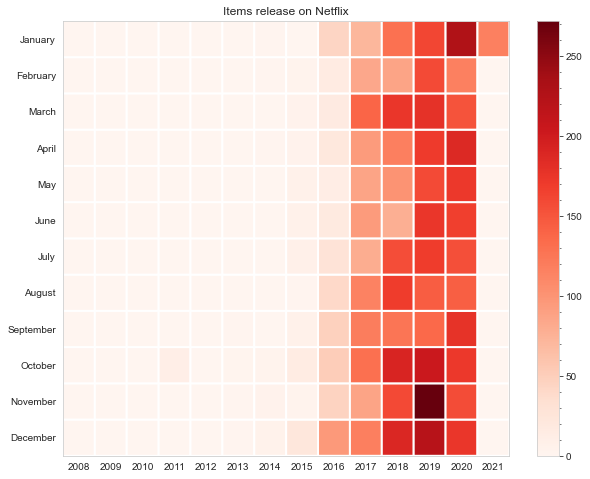

In [7]:
plt.figure(figsize=(10, 8))
res = df_dates.groupby('year')['month'].value_counts().unstack().fillna(0)[mois]
res=res.T
plt.pcolor(res, cmap='Reds', edgecolors='white', linewidths=2) # heatmap
plt.xticks(np.arange(0.5, len(res.columns), 1), res.columns)
plt.yticks(np.arange(0.5, len(res.index), 1), res.index)

plt.title('Items release on Netflix')
cbar = plt.colorbar()
cbar.ax.minorticks_on()
plt.show()


### Evolution of the TV shows and movies release

In [8]:
df_movies=df[df["type"] == "Movie"]
df_tvshows=df[df["type"] == "TV Show"]
df["date_added"] = pd.to_datetime(df['date_added'])
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month


In [9]:
df_movies['date_added']=pd.to_datetime(df_movies['date_added'])
df_tvshows['date_added']=pd.to_datetime(df_tvshows['date_added'])
df_movies['year_added']=df_movies['date_added'].dt.year
df_tvshows['year_added']=df_tvshows['date_added'].dt.year

<ipython-input-9-34a32359bcc0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['date_added']=pd.to_datetime(df_movies['date_added'])
<ipython-input-9-34a32359bcc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tvshows['date_added']=pd.to_datetime(df_tvshows['date_added'])
<ipython-input-9-34a32359bcc0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

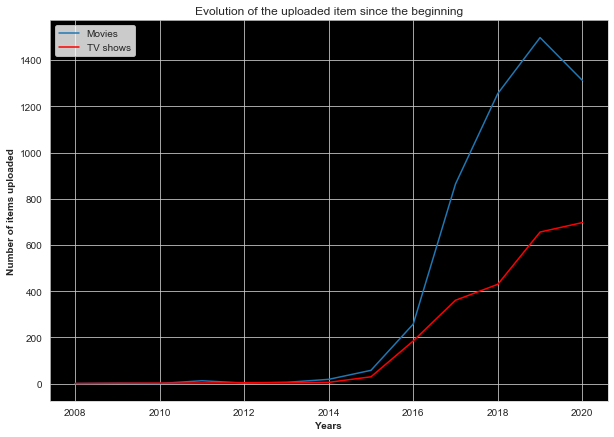

In [10]:
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.set_facecolor("black")
df_movies["year_added"].value_counts().sort_index().iloc[:-1].plot(x='index',y='year_added',label='Movies')
df_tvshows["year_added"].value_counts().sort_index().iloc[:-1].plot(x='index',y='year_added',label='TV shows',color='red')
plt.title('Evolution of the uploaded item since the beginning')
plt.xlabel("Years", fontweight='bold')
plt.ylabel("Number of items uploaded", fontweight='bold')
plt.legend()

### Average duration of items 
#### Movies

In [11]:
df_movies['duration']=df_movies.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)
df_movies['duration']=df_movies['duration'].astype(int)

<ipython-input-11-607d25cafecb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['duration']=df_movies.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)
<ipython-input-11-607d25cafecb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['duration']=df_movies['duration'].astype(int)


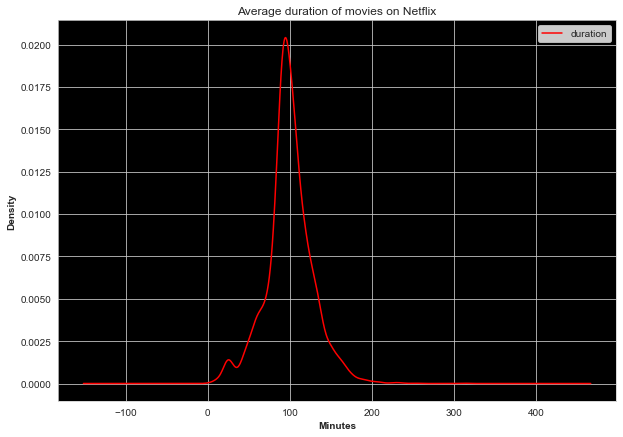

In [12]:
fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.set_facecolor("black")
df_movies['duration'].plot(kind='density',color='red')
plt.title('Average duration of movies on Netflix')
plt.xlabel("Minutes", fontweight='bold')
plt.ylabel("Density", fontweight='bold')
plt.legend()


## Country of items

In [13]:
df_indic_1= df['country'].value_counts().sort_values(ascending=False)
fig = pd.DataFrame(df_indic_1)[:10].style.background_gradient(cmap='Reds')\
                                .set_properties(**{'text-align':'center'})

In [14]:
fig

,country
United States,2555
India,923
United Kingdom,397
Japan,226
South Korea,183
Canada,177
Spain,134
France,115
Egypt,101
Mexico,100


C:\Users\thoma\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Top 10 Countries of items')

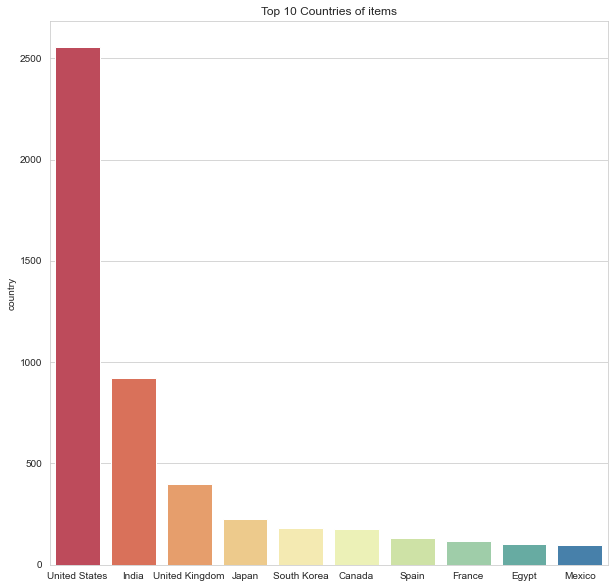

In [15]:
plt.figure(figsize=(10,10))
sns.barplot(df_indic_1[:10].index,df_indic_1[:10], palette='Spectral')
plt.title('Top 10 Countries of items')

In [16]:
df_indic_1[:10].index


Index(['United States', 'India', 'United Kingdom', 'Japan', 'South Korea',
       'Canada', 'Spain', 'France', 'Egypt', 'Mexico'],
      dtype='object')

# Recommender System


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
object_tfid = TfidfVectorizer(stop_words='english')
#Deal with empty descriptions
df['description'] = df['description'].fillna('')
tfidf_matrix = object_tfid.fit_transform(df['description'])


In [19]:
from sklearn.metrics.pairwise import linear_kernel
# matrix cosine metrics
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [20]:
# giving id to each item
id_item=pd.Series(df.index, index=df['title'])

In [21]:
def recomender(title, cosine_sim=cosine_sim):
    idx = id_item[title]

    scores = list(enumerate(cosine_sim[idx]))

    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[:10]

    movie_index = [i[0] for i in scores]

    # Return the top 10 most similar movies
    print("*"*40+"\n Recommendation for "+title+"\n"+"*"*40)
    print(df['title'].iloc[movie_index])
    print("*"*42)

In [22]:
#Recommand a Korean Drama, we see that some recomendations correlated to K-dramas
recomender('Itaewon Class')

****************************************
 Recommendation for Itaewon Class
****************************************
3083                  Itaewon Class
5161                     Reply 1988
2777                      Hollywood
5130                Record of Youth
4740          Pahuyut Fighting Beat
3968             Marvel's Luke Cage
4373              Mystic Pop-up Bar
625     Austin Powers in Goldmember
1300                         Cheers
7666                  World of Winx
Name: title, dtype: object
******************************************


In [23]:
recomender('Spider-Man 3')

****************************************
 Recommendation for Spider-Man 3
****************************************
5753                                    Spider-Man 3
1893         Dumb and Dumberer: When Harry Met Lloyd
3958    Marvel & ESPN Films Present: 1 of 1: Genesis
327                                After Porn Ends 3
7781                                            Zoom
1432                        Club Friday The Series 7
1433                        Club Friday The Series 8
7215                 Trevor Noah: Afraid of the Dark
3213                        JoJo's Bizarre Adventure
5112                                        Reaction
Name: title, dtype: object
******************************************


In [24]:
recomender('American Horror Story')

****************************************
 Recommendation for American Horror Story
****************************************
468                                American Horror Story
583                                 Arrested Development
2832                                      House of Cards
924                             Bill Nye Saves the World
2494                                      Goodnight DJ 1
4677                             Orange Is the New Black
3075                          It Takes a Man and a Woman
2405                                       Ghosts of War
5548    Shaurya: It Takes Courage to Make Right... Right
1548                              Cuba and the Cameraman
Name: title, dtype: object
******************************************


# List of items that you can select, then display the next cell to get the recomendation

In [45]:
import ipywidgets as widgets
items_title=df['title'].values
output=widgets.Dropdown(options=items_title,description='Title : ',disabled=False)
display(output)

Dropdown(description='Title : ', options=('3%', '7:19', '23:59', '9', '21', '46', '122', '187', '706', '1920',…

In [51]:
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print( "changed to %s" % change['new'])

recomender(output.value)

****************************************
 Recommendation for Pulp Fiction
****************************************
5002                           Pulp Fiction
5078                         Raja Natwarlal
5651                              Skiptrace
7459                 Waiting for "Superman"
5739                               Sparring
2476                            Good Burger
5942                         Swiss Army Man
3579    Lego DC Comics: Batman Be-Leaguered
4564                       Ocean's Thirteen
5246                               Rocky II
Name: title, dtype: object
******************************************
